In [1]:
from netCDF4 import Dataset
import numpy as np
import matplotlib.pyplot as plt
import time
import matplotlib.animation as animation
import datetime
from matplotlib import rc
from mpl_toolkits.basemap import Basemap
from progressbar import ProgressBar
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['rc']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
class ParticleData(object):
    def __init__(self):
        self.id = []

def load_particles_file(fname, varnames):
    T = ParticleData()
    pfile = Dataset(fname, 'r')
    T.id = pfile.variables['trajectory'][:]

    for v in varnames:
        if v is 'startloc':
            setattr(T, v, pfile.variables[v][:,0])
        elif v is 'time':
            T.time = np.ma.filled(np.mean(pfile.variables[v][:],0), np.nan)
        else:
            setattr(T, v, pfile.variables[v][:])

    T.startlon = T.lon[0, 0]
    T.startlat = T.lat[0, 0]

    return T

In [3]:
T = {}
for beachloc in range(17):
    fname = 'plastic_cyprusbeaches_s%0.3d_array.nc' % beachloc
    T[beachloc] = load_particles_file(fname, ['lon', 'lat'])
    T[beachloc].startloc = beachloc

In [4]:
pylab.rcParams['figure.figsize'] = (10, 14)
def makemov(Ts):
    fig = plt.figure()
    minlon = 385  # min([np.amin(Ts[z].lon) for z in Ts])
    maxlon = max([np.amax(Ts[z].lon) for z in Ts])
    minlat = min([np.amin(Ts[z].lat) for z in Ts])
    maxlat = max([np.amax(Ts[z].lat) for z in Ts])

    frames = np.arange(0, Ts[0].lon.shape[1])
    
    def setmap(i, T):
        ax = fig.add_subplot(6, 3, i+1)
        ttl = ax.set_title('Particles from beach ' + str(z+1) + '\n 0 days back-tracked')
        m = Basemap(projection='cea', ax=ax, llcrnrlat=minlat-1, urcrnrlat=maxlat+1,\
                    llcrnrlon=minlon-1, urcrnrlon=maxlon+1, resolution='i')
        m.drawcoastlines()
        m.fillcontinents(color='burlywood')
        xs, ys = m(T.lon[:, frames[0]], T.lat[:, frames[0]])
        m.scatter(xs, ys, c='r', s=50, edgecolor='k')
        return m, ttl

    def setscat(T, m):
        xs, ys = m(T.lon[:, frames[0]], T.lat[:, frames[0]])
        scat = m.scatter(xs, ys, c='C'+str(T.startloc), s=10, edgecolor='k')
        return scat

    m = {}
    scat = {}
    ttl = {}
    for i, z in enumerate(Ts):
        m[z], ttl[z] = setmap(i, Ts[z])
        scat[z] = setscat(Ts[z], m[z])
    
    def animate(t):
        for z in Ts:
            ttl[z].set_text('Particles from beach ' + str(z+1) + '\n' + str(t) + ' days back-tracked')
            scat[z].set_offsets(np.matrix(m[z](Ts[z].lon[:, t], Ts[z].lat[:, t])).transpose())
        return scat

    rc('animation', html='html5')
    anim = animation.FuncAnimation(fig, animate, frames=frames,
                                   interval=100, blit=False)
    plt.close()
    return anim

makemov(T)

/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:1767: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  axisbgc = ax.get_axis_bgcolor()
/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:3222: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:3231: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


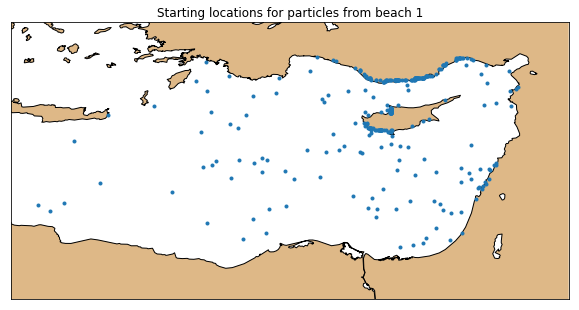

In [5]:
minlon = 385  # min([np.amin(T[z].lon) for z in T])
maxlon = max([np.amax(T[z].lon) for z in T])
minlat = min([np.amin(T[z].lat) for z in T])
maxlat = max([np.amax(T[z].lat) for z in T])
m = Basemap(projection='cea', llcrnrlat=minlat-1, urcrnrlat=maxlat+1,\
            llcrnrlon=minlon-1, urcrnrlon=maxlon+1, resolution='i')
m.drawcoastlines()
m.fillcontinents(color='burlywood')

xs, ys = m(T[0].lon[:,-1], T[0].lat[:,-1])
plt.plot(xs, ys,'.')
plt.title('Starting locations for particles from beach 1')
plt.show()